# Testing CrossSection

In [1]:
%matplotlib inline

import os
import re
import sys
import numpy
import scipy

try:
   import cPickle as pickle
except:
   import pickle

sys.path.append('/Users/mpagani/Projects/hmtk/')
sys.path.append('/Users/mpagani/Projects/original/oq-engine/')
sys.path.append('/Users/mpagani/Projects/oq-subduction/')

import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from hmtk.seismicity.selector import CatalogueSelector
from hmtk.subduction.cross_sections import CrossSection
from openquake.hazardlib.geo.geodetic import geodetic_distance

from openquake.subduction.utils import plot_planes_at, mecclass

## Load trench data

In [2]:
fin = open('./../data/trench.xy', 'r')
trench = []
for line in fin: 
    aa = re.split('\s+', re.sub('^\s+', '', line))
    trench.append((float(aa[0]), float(aa[1])))
fin.close()
trc = numpy.array(trench)

## Load catalogue

In [3]:
cat = pickle.load(open("./../data/catalogue_ext_cac.p", "rb" ))

In [4]:
olo = -104; ola = 18; lnght = 600; strike = 25
#olo = -93; ola = 14; lnght = 600; strike = 25
olo = -92.5; ola = 13; lnght = 600; strike = 25

#olo = -85.0; ola = 9; lnght = 600; strike = 30 # Costa Rica
#olo = -85.5; ola = 9.5; lnght = 600; strike = 30 # Costa Rica 2012 M=7.2 

#olo = -94.0; ola = 14; lnght = 600; strike = 30 # 
#olo = -95.0; ola = 15; lnght = 600; strike = 25 # 
#olo = -106.4797; ola = 21.2508; lnght = 400; strike = 88.705250412
#olo = -60; ola = 13; lnght = 600; strike = 270
#olo = -84; ola = 8; lnght = 600; strike = 30 # Panama

csec = CrossSection(olo, ola, [lnght], [strike])
idxs = csec.get_eqks_within_buffer(cat, 50.)

boo = numpy.zeros_like(cat.data['magnitude'], dtype=int)
boo[idxs] = 1

selector = CatalogueSelector(cat, create_copy=True)
newcat = selector.select_catalogue(boo)

In [5]:
midlo = (min(cat.data['longitude'])+max(cat.data['longitude']))/2
midla = (min(cat.data['latitude'])+max(cat.data['latitude']))/2
minlo = min(cat.data['longitude'])
minla = min(cat.data['latitude'])
maxlo = max(cat.data['longitude'])
maxla = max(cat.data['latitude'])

## Plot catalogue and trench

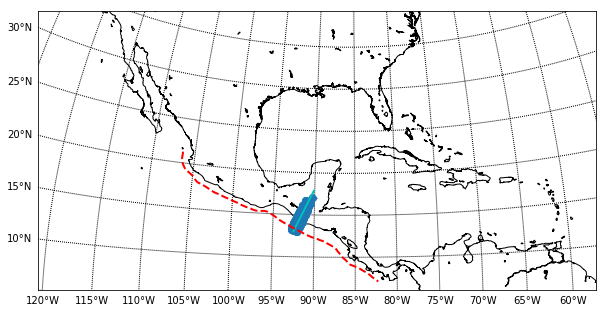

In [6]:
fig = plt.figure(figsize=(10,8))

m = Basemap(llcrnrlon=minlo, llcrnrlat=minla,
            urcrnrlon=maxlo, urcrnrlat=maxla,
            resolution='i', projection='tmerc', 
            lon_0=midlo, lat_0=midla)

m.drawcoastlines()
m.drawmeridians(numpy.arange(numpy.floor(minlo/10.)*10,
                             numpy.ceil(maxlo/10.)*10,5.),
               labels=[False, False, False, True])
m.drawparallels(numpy.arange(numpy.floor(minla/10.)*10,
                             numpy.ceil(maxla/10.)*10,5.),
               labels=[True, False, False, False])

x, y = m(cat.data['longitude'], cat.data['latitude'])
#plt.plot(x, y, 'x', zorder=10)

x, y = m(newcat.data['longitude'], newcat.data['latitude'])
plt.plot(x, y, 'o')

x, y = m(trc[:, 0], trc[:, 1])
plt.plot(x, y, '--r', linewidth=2, zorder=20)

x, y = m(csec.plo, csec.pla)
plt.plot(x, y, '-c', linewidth=2, zorder=19)

In [7]:
def create_legend():
    msizes = numpy.array([3, 4, 5, 6, 7, 8])**2
    l1, = plt.plot([],[], 'or', markersize=msizes[0])
    l2, = plt.plot([],[], 'or', markersize=msizes[1])
    l3, = plt.plot([],[], 'or', markersize=msizes[2])
    l4, = plt.plot([],[], 'or', markersize=msizes[3])
    labels = ['M3', 'M4', 'M5', 'M6']
    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=True, fontsize=12,
                      handlelength=2, loc=3, borderpad = 1.8,
                      handletextpad=1, title='Magnitude', scatterpoints = 1)

In [8]:
from netCDF4 import Dataset
def get_topography(cross_section, minlo, maxlo, minla, maxla):
    """
    See http://www.trondkristiansen.com/?page_id=846
    """
    toponame='/Users/mpagani/Data/ETOPO1_Bed_g_gmt4.grd'
    toponame='/Users/mpagani/Data/globalGTOPO30.grd'
    toponame='/Users/mpagani/Data/etopo5.nc'

    etopo1 = Dataset(toponame,'r')
 
    # ETOPO1
    #lons = etopo1.variables["x"][:]
    #lats = etopo1.variables["y"][:]

    # ETOPO5
    lons = etopo1.variables["topo_lon"][:]
    lats = etopo1.variables["topo_lat"][:]

    dlt = 0.50
    res = findSubsetIndices(minla-dlt, maxla+dlt, minlo-dlt, maxlo+dlt, lats, lons)

    lon, lat = numpy.meshgrid(lons[res[0]:res[1]],lats[res[2]:res[3]])
    print ("Extracted data for area: (%s,%s) to (%s,%s)"%(lon.min(), lat.min(),
                                                         lon.max(), lat.max()))
    bathy = etopo1.variables["topo"][int(res[2]):int(res[3]),int(res[0]):int(res[1])]


    lonf = lon.flatten() 
    latf = lat.flatten()
    batf = bathy.flatten()
    print ('fl: %.f %f' % (lonf.shape, latf.shape))
    idx = cross_section.get_grd_nodes_within_buffer(lonf, latf, 25., minlo, maxlo, minla, maxla)
    
    return lonf[idx], latf[idx], batf[idx]

In [9]:
def findSubsetIndices(min_lat, max_lat, min_lon, max_lon,lats,lons):
    """
    Array to store the results returned from the function. This is taken
    from http://www.trondkristiansen.com/?page_id=846
    """

    res=numpy.zeros((4),dtype=numpy.float64)
    minLon=min_lon; maxLon=max_lon
    
    distances1 = []; distances2 = []
    indices=[]; index=1
    
    for point in lats:
        s1 = max_lat-point # (vector subtract)
        s2 = min_lat-point # (vector subtract)
        distances1.append((numpy.dot(s1, s1), point, index))
        distances2.append((numpy.dot(s2, s2), point, index-1))
        index=index+1     
    distances1.sort()
    distances2.sort()
    indices.append(distances1[0])
    indices.append(distances2[0])
    
    distances1 = []; distances2 = []; index=1
   
    for point in lons:
        s1 = maxLon-point # (vector subtract)
        s2 = minLon-point # (vector subtract)
        distances1.append((numpy.dot(s1, s1), point, index))
        distances2.append((numpy.dot(s2, s2), point, index-1))
        index=index+1
        
    distances1.sort()
    distances2.sort()
    indices.append(distances1[0])
    indices.append(distances2[0])
    
    """ Save final product: max_lat_indices,min_lat_indices,max_lon_indices,min_lon_indices"""
    minJ=indices[1][2]
    maxJ=indices[0][2]
    minI=indices[3][2]
    maxI=indices[2][2]
    
    res[0]=minI; res[1]=maxI; res[2]=minJ; res[3]=maxJ;
    return res

In [10]:
def get_crust1pt0_moho_depth(cross_sect, minlo=-180, maxlo=180, minla=-90, maxla=90):
    filename = "/Users/mpagani/GDrive/GEM_hazard/Data/Geology/CRUST1.0/depthtomoho.xyz"
    datal = []
    for line in open(filename, 'r'):
        xx = re.split('\s+', re.sub('\s+$', '', re.sub('^\s+', '', line)))
        datal.append([float(val) for val in xx])
    dataa = numpy.array(datal)
    idxs = cross_sect.get_grd_nodes_within_buffer(dataa[:,0], dataa[:,1], 100., minlo, maxlo, minla, maxla)
    if len(idxs):
        boo = numpy.zeros_like(dataa[:, 0], dtype=int)
        boo[idxs[0]] = 1
        return dataa[idxs,:]
    else:
        return None

In [11]:
mnlo = min(csec.plo)
mnla = max(csec.plo)
mxlo = min(csec.pla)
mxla = max(csec.pla)
print (mnlo, mnla, mxlo, mxla)

-92.5 -90.1067184455 13 17.8783397174


In [12]:
def gridding(xmin, xmax, ymin, ymax, stepx, stepy, datax, datay, mag): 

    idxo = numpy.nonzero((datax > xmin) & (datax < xmax) & 
                         (datay > ymin) & (datay < ymax))

    idx = idxo[0].astype(int)
    datax = datax[idx]
    datay = datay[idx]

    resol = 5.0
    x = numpy.arange(numpy.floor(xmin/resol)*resol, 
                     numpy.ceil(xmax/resol)*resol+resol, stepx)
    y = numpy.arange(numpy.floor(ymin/resol)*resol, 
                     numpy.ceil(ymax/resol)*resol+resol, stepy)
    X, Y = numpy.meshgrid(x, y)
    idx = numpy.round(datax/stepx)
    idy = numpy.round(datay/stepy)

    Zn = numpy.zeros_like(X)
    Zm = numpy.ones_like(X) * 1e-10

    for ix, iy, mag in zip(list(idx), list(idy), mag):
        Zn[iy, ix] += 1
        Zm[iy, ix] += 10**(1.5*mag+9.05)

    return X, Y, Zn, Zm

In [13]:
def get_cmt(cmt_cat, cross_sect, lomin, lomax, lamin, lamax):
    loc = cmt_cat.data['longitude']
    lac = cmt_cat.data['latitude']
    idxs = cross_sect.get_grd_nodes_within_buffer(loc, lac, 50., lomin, lomax, lamin, lamax)
    return idxs

In [14]:
import matplotlib
import scipy.interpolate as interpolate
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

## Getting MOHO

In [15]:
moho = numpy.squeeze(get_crust1pt0_moho_depth(csec, minlo, maxlo, minla, maxla))

## Getting topography

## Reading GCMT

In [16]:
from hmtk.parsers.catalogue.gcmt_ndk_parser import ParseNDKtoGCMT
from obspy.imaging.beachball import beach

gcmt_filename = '/Users/mpagani/Data/catalogues/gcmt/jan76_dec13.ndk'
parser = ParseNDKtoGCMT(gcmt_filename)
cat_gcmt = parser.read_file()

Parsing catalogue ...
complete. Contains 40514 moment tensors


In [17]:
print (sorted(cat_gcmt.data.keys()))
#print cat_gcmt.gcmts
print (cat_gcmt.data['depthError'])

['Agency', 'ErrorStrike', 'SemiMajor90', 'SemiMinor90', 'azimuth_b', 'azimuth_p', 'azimuth_t', 'centroidID', 'comment', 'day', 'depth', 'depthError', 'dip1', 'dip2', 'e_rel', 'eigenvalue_b', 'eigenvalue_p', 'eigenvalue_t', 'eventID', 'f_clvd', 'flag', 'hour', 'latitude', 'longitude', 'magnitude', 'magnitudeType', 'minute', 'moment', 'month', 'plunge_b', 'plunge_p', 'plunge_t', 'rake1', 'rake2', 'second', 'sigmaMagnitude', 'strike1', 'strike2', 'timeError', 'year']
[ 0.  0.  0. ...,  0.  0.  0.]


## Read Slab 1.0

In [18]:
grdname = "/Users/mpagani/Data/subduction/mex_slab1.0_clip.xyz"
slab1pt0 = []
for line in open(grdname):
    aa = re.split('\s+', line)
    if not re.search('[a-z]', aa[2]):
        slab1pt0.append([float(aa[0]), float(aa[1]), float(aa[2])])
slab1pt0or = numpy.asarray(slab1pt0)

In [19]:
idx = numpy.nonzero(slab1pt0or[:,0] > 180)
slab1pt0 = slab1pt0or
if len(idx[0]):
    slab1pt0[idx[0], 0] = slab1pt0[idx[0], 0] - 360.
idxslb = csec.get_grd_nodes_within_buffer(slab1pt0[:,0], slab1pt0[:,1], 2.5, minlo, maxlo, minla, maxla)
slab1pt0 = numpy.squeeze(slab1pt0[idxslb,:])

## Processing GCMT

In [20]:
tmp_idx_cmt = get_cmt(cat_gcmt, csec, minlo, maxlo, minla, maxla)

idx_cmt = []
cnt = 0
for idx in tmp_idx_cmt:
    tmp = cat_gcmt.gcmts[idx].centroid.depth_type
    # print tmp, 
    if re.search(tmp,'FREE') or re.search(tmp, 'BDY '):
        idx_cmt.append(idx)
        cnt += 1
        #print cnt,
    #print ''
#print idx_cmt

print ('Number of initial CMT events %d and number of selected eqks %d' % (len(tmp_idx_cmt), len(idx_cmt)))

print (min(cat_gcmt.data['longitude'][tmp_idx_cmt]))
print (max(cat_gcmt.data['longitude'][tmp_idx_cmt]))
print (min(cat_gcmt.data['latitude'][tmp_idx_cmt]))
print (max(cat_gcmt.data['latitude'][tmp_idx_cmt]))

Number of initial CMT events 114 and number of selected eqks 102
-92.63
-91.19
13.24
16.1


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in greater


Max histogram and max rounded: 85 90


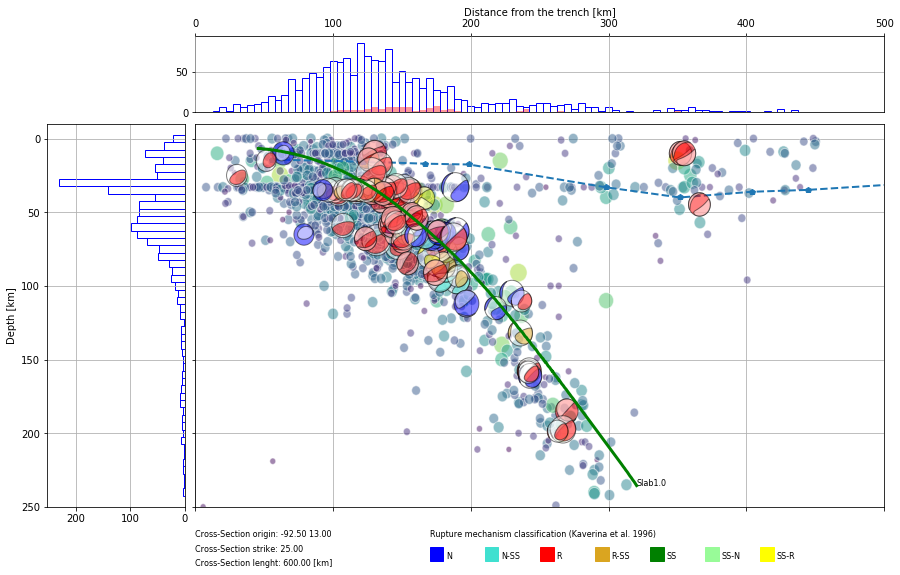

In [24]:
max_depth = 250
ypad = 10
max_dist = 450
fig_length = 15

kaverina = {'N' : 'blue',
            'SS' : 'green',
            'R': 'red',
            'N-SS': 'turquoise',
            'SS-N': 'palegreen',
            'R-SS': 'goldenrod',
            'SS-R': 'yellow' }

fig_width = fig_length * (max_depth+ypad) / max_dist

fig = plt.figure(figsize=(fig_length, fig_width))
gs = gridspec.GridSpec(2, 2, 
                       width_ratios=[1,5],
                       height_ratios=[1,5])
# set the spacing between axes
gs.update(wspace=0.025, hspace=0.05) 

# Axis 1 - Upper right
ax1 = plt.subplot(gs[1])
plt.axis('on')
ax1.set_autoscale_on(False)

# Axis 2 - Lower left
ax2 = plt.subplot(gs[2])
plt.axis('on')
ax2.set_autoscale_on(False)

# Axis 3 - Lower Right
ax3 = plt.subplot(gs[3])
plt.axis('on')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_autoscale_on(False)

# Axis - Upper left
ax0 = plt.subplot(gs[0])
plt.axis('off')
ax0.set_autoscale_on(False)

# ----- 
# MAIN PANEL
ax3 = plt.subplot(gs[3])
note = 'Cross-Section origin: %.2f %.2f' % (olo, ola)
ax3.annotate(note, xy=(0.0, max_depth+20), xycoords='data', 
                   annotation_clip=False, fontsize=8)

note = 'Cross-Section strike: %.2f' % (strike)
ax3.annotate(note, xy=(0.0, max_depth+30), xycoords='data', 
                   annotation_clip=False, fontsize=8)

note = 'Cross-Section lenght: %.2f [km]' % (lnght)
plt.gca().annotate(note, xy=(0.0, max_depth+40), xycoords='data', 
                   annotation_clip=False, fontsize=8)

# -----
# LEGEND for FOCAL MECHANISMS
x = 170
xstep = 40
y = max_depth+27
patches = []
note = 'Rupture mechanism classification (Kaverina et al. 1996)' 
plt.gca().annotate(note, xy=(x, max_depth+20), xycoords='data', 
                   annotation_clip=False, fontsize=8)
for key in sorted(kaverina):   
    box = matplotlib.patches.Rectangle(xy=(x, y), width=10, height=10, 
                                       color=kaverina[key], clip_on=False)
    plt.gca().annotate(key, xy=(x+12,y+8), annotation_clip=False, fontsize=8)
    x += xstep
    plt.gca().add_patch(box)


# -----
# Compute distance between the origin of the cross-section and each selected earthquake

dsts = geodetic_distance(olo, ola, newcat.data['longitude'], newcat.data['latitude'])
#xg, yg, zgn, zgm = gridding(0, max_dist, 0, max_depth, 5, 5, dsts, newcat.data['depth'][:],
#                            newcat.data['magnitude'][:])
sze = (newcat.data['magnitude'])**0.5
patches = []
for dst, dep, mag in zip(dsts, newcat.data['depth'], newcat.data['magnitude']):
    circle = Circle((dst, dep), (mag*0.5)**1.5, ec='white')
    patches.append(circle)
colors = newcat.data['magnitude']
p = PatchCollection(patches, zorder=6, edgecolors='white')
p.set_alpha(0.5)
p.set_array(numpy.array(colors))
plt.gca().add_collection(p)

#plt.colorbar(p, fraction=0.1)
"""
"""

# -----
# Compute histograms
tmp_mag = newcat.data['magnitude'][:]
tmp_dep = newcat.data['depth'][:]
iii = numpy.nonzero((tmp_mag > 3.5) & (tmp_dep > 0.))
edges_dep = numpy.arange(0, max_depth, 5)
edges_dist = numpy.arange(0, max_dist, 5)
seism_depth_hist = scipy.histogram(tmp_dep[iii], edges_dep)
seism_dist_hist = scipy.histogram(dsts[iii], edges_dist)

# -----
# MOHO
mdsts = geodetic_distance(olo, ola, moho[:, 0], moho[:, 1])
iii = numpy.argsort(mdsts)
plt.plot(mdsts[iii], -1*moho[iii, 2], '--p', zorder=10, linewidth=2)

# -----
# TOPOGRAPHY
if 0:
    tdsts = geodetic_distance(olo, ola, los, las)
    iii = numpy.argsort(tdsts)
    plt.plot(tdsts[iii], -1*deps[iii]/1000, '-k', zorder=1, linewidth=2)

# -----
# Focal mechanisms
cmt_dst = geodetic_distance(olo, ola, cat_gcmt.data['longitude'][idx_cmt], 
                                      cat_gcmt.data['latitude'][idx_cmt]) 
cmt_dep = cat_gcmt.data['depth'][idx_cmt]
cmts = numpy.array(cat_gcmt.gcmts)[idx_cmt]

ax = plt.subplot(gs[3])

for idx, ddd, dep, eve, mag, yea in zip(idx_cmt, list(cmt_dst), list(cmt_dep), list(cmts), 
                                        cat_gcmt.data['magnitude'][idx_cmt],
                                        cat_gcmt.data['year'][idx_cmt]):

    if yea > 1000 and mag > 1.0:

        # Kaverina classification
        plungeb = cat_gcmt.data['plunge_b'][idx]
        plungep = cat_gcmt.data['plunge_p'][idx]
        plunget = cat_gcmt.data['plunge_t'][idx]
        mclass = mecclass(plunget, plungeb, plungep)

        com = eve.moment_tensor._to_6component()
        eve.nodal_planes.nodal_plane_1
        bcc = beach(com, xy=(ddd, dep), width=eve.magnitude*3, 
                    linewidth=1, zorder=20, size=mag, facecolor=kaverina[mclass])
        bcc.set_alpha(0.5)
        ax.add_collection(bcc)

"""
        plot_planes_at(ddd, dep, 
                       [eve.nodal_planes.nodal_plane_1['strike'], eve.nodal_planes.nodal_plane_2['strike']], 
                       [eve.nodal_planes.nodal_plane_1['dip'], eve.nodal_planes.nodal_plane_2['dip']],
                       [mag, mag], 
                       strike_cs=strike, 
                       dip_cs=90., 
                       aratio=1.0, 
                       color=kaverina[mclass], 
                       linewidth=2.0,
                       axis=ax)

"""

gcmt_dist_hist = scipy.histogram(cmt_dst, edges_dist)

# -----
# SLAB 1.0
slb_dst = geodetic_distance(olo, ola, slab1pt0[:, 0], slab1pt0[:, 1])
slb_dep = slab1pt0[:, 2]
iii = numpy.argsort(slb_dst)
plt.plot(slb_dst[iii], -1*slb_dep[iii], '-g', linewidth=3, zorder=30)
plt.text(slb_dst[iii[-1]], -1*slb_dep[iii[-1]], 'Slab1.0', fontsize=8)

# -----
# Final adjustments 
ax3 = plt.subplot(gs[3])
ax3.autoscale(enable=False, tight=True)
ax3.invert_yaxis()
plt.xlim([0, 500])
plt.ylim([max_depth, -ypad])
ax3.set_ybound(lower=max_depth, upper=-ypad)
ax3.grid(which='both', zorder=20)

# ----- 
# DEPTH PANEL
ax2 = plt.subplot(gs[2])
plt.barh(edges_dep[:-1], seism_depth_hist[0], height=numpy.diff(edges_dep)[0], fc='none', ec='blue')
plt.ylabel('Depth [km]')
ax2.grid(which='both', zorder=20)
xmax = numpy.ceil(max(seism_depth_hist[0])/10.)*10.
ax2.set_xlim([0, xmax+xmax*0.05])
ax2.set_ylim([max_depth, -ypad])
ax2.set_ybound(lower=max_depth, upper=-ypad)
ax2.invert_xaxis()

# ----- 
# DISTANCES PANEL
ax1 = plt.subplot(gs[1])
plt.bar(edges_dist[:-1], height=seism_dist_hist[0], width=numpy.diff(edges_dist)[0], fc='none', ec='blue')
plt.bar(edges_dist[:-1], height=gcmt_dist_hist[0], width=numpy.diff(edges_dist)[0], fc='red', alpha=0.4)
plt.xlim([0, xmax+xmax*0.05])
# Moving ticks on top
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_axisbelow(False)
plt.xlabel('Distance from the trench [km]')
ax1.grid(which='both', zorder=20)
print ('Max histogram and max rounded: %d %d' % (max(seism_dist_hist[0]), numpy.ceil(max(seism_dist_hist[0])/10.)*10.))
ymax = numpy.ceil(max(seism_dist_hist[0])/10.)*10.
ax1.set_ylim([0, ymax+ymax*0.05])
ax1.set_xlim([0, 500])

# -----
# Adding the colorbar
# See http://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
axes = []
#for gg in gs:
#    axes.append(plt.subplot(gg))
#fig.colorbar(p, ax=axes, fraction=0.01, pad=0.01)

In [22]:
import ipywidgets as widgets
w = widgets.HTML()

def onclick(event):
    values = []
    w.value = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f'%(
              event.button, event.x, event.y, event.xdata, event.ydata)
    values.add(event.x, event.y)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

Widget Javascript not detected.  It may not be installed or enabled properly.
